In [213]:
import pandas as pd
import datetime as dt
import numpy as np
import json
import matplotlib.pyplot as plt
plt.style.use("dark_background")

In [279]:
df = pd.read_hdf('OrderBookSubscriptionCONSTANT_TABLE_DEPTH_1.h5')

In [280]:
df.head()

,CHANGE_ID,NAME_INSTRUMENT,TIMESTAMP_VALUE,BID_0_PRICE,BID_0_AMOUNT,ASK_0_PRICE,ASK_0_AMOUNT
0,0.0,601.0,1.682961e+12,-1.0,-1.0,-1.0000,-1.0
1,0.0,602.0,1.682961e+12,-1.0,-1.0,0.0005,649.0
2,0.0,603.0,1.682961e+12,-1.0,-1.0,-1.0000,-1.0
3,0.0,604.0,1.682961e+12,-1.0,-1.0,0.0005,485.0
4,0.0,605.0,1.682961e+12,-1.0,-1.0,-1.0000,-1.0


In [174]:
def to_datetime(dt64):
    return dt.datetime.utcfromtimestamp(dt64 * 1e-3)

def get_tenor(tag):
    if tag == 'ETH-PERPETUAL':
        return dt.datetime(2023, 5, 2)
    res = tag[4:]
    if len(res) > 7:
        r = len(re.findall('-[1-9].*',res)[0])
        res = res[:-r]
    return dt.datetime.strptime(res, '%d%b%y')

def get_strike(tag):
    if tag == 'ETH-PERPETUAL' or len(tag) < 12:
        return 0
    else:
        res = tag[4:]
        res = re.findall('-[1-9].*',res)[0]
        res = res[1:-2]
        return int(res)

def get_instrument(tag):
    if tag == 'ETH-PERPETUAL':
        return 0
    if len(tag) < 12:
        return 1
    else:
        C = tag[-1]
        return 2 if C == 'C' else 3

In [160]:
with open('../../noa/docs/quant/deribit/TradingInterfaceBot/DataBase/InstrumentNameToIdMap.json') as f:
    inst_map = json.load(f)

In [161]:
id_map = {v: k for k, v in inst_map.items()}

In [281]:
df = df[(df.ASK_0_PRICE > 0) & (df.BID_0_PRICE > 0)]

In [282]:
df['dt'] = df.TIMESTAMP_VALUE.map(to_datetime)

In [283]:
df['instrument_tag'] = df['NAME_INSTRUMENT'].astype(np.int64).map(id_map)

In [284]:
df['price'] = df.ASK_0_PRICE

In [285]:
df['tenor'] = df.instrument_tag.map(get_tenor)

In [286]:
df['strike'] = df.instrument_tag.map(get_strike)

In [287]:
df['instrument'] = df.instrument_tag.map(get_instrument)

In [288]:
df = df[df.price > 0][['dt', 'instrument', 'price', 'tenor', 'strike',]].copy()

In [339]:
df.head()

,dt,instrument,price,tenor,strike
5,2023-05-01 17:07:13.674,3,0.0010,2023-05-02,1750
7,2023-05-01 17:07:17.707,3,0.0020,2023-05-02,1800
8,2023-05-01 17:07:18.715,2,0.0135,2023-05-02,1825
9,2023-05-01 17:07:20.919,3,0.0020,2023-05-02,1800
0,2023-05-01 17:07:21.128,2,0.0135,2023-05-02,1825


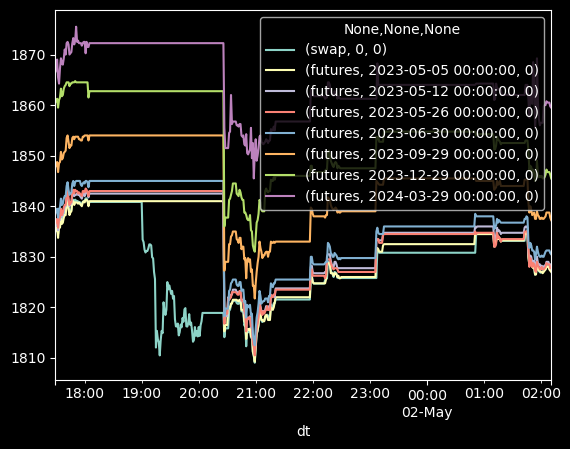

In [442]:
data = df[df.instrument == 0][['dt', 'price']].set_index('dt')
data = data.resample('1min').ohlc().ffill()[('price', 'close')]\
    .rename(('swap', 0, 0))
futures = df[df.instrument == 1]
for tenor in sorted(futures.tenor.unique()):
    futures_t = futures[futures.tenor == tenor][['dt', 'price']].set_index('dt')
    futures_t = futures_t.resample('1min').ohlc().ffill()[('price', 'close')]\
        .rename(('futures', tenor, 0))
    data = pd.merge(data, futures_t, on='dt', how='inner')
data = data.ffill()
data = data.dropna(axis=1)
data = data.dropna()
data.plot();

In [443]:
puts = df[(df.instrument == 3) & (df.strike < 1900)]
for tenor in sorted(puts.tenor.unique()):
    for strike in sorted(puts.strike.unique()):
        put = puts[(puts.tenor == tenor) & (puts.strike == strike)][['dt', 'price']].set_index('dt')
        if len(put) > 0:
            put = put.resample('1min').ohlc().ffill()[('price', 'close')]\
                .rename(('put', tenor, strike))
            data = pd.merge(data, put, on='dt', how='outer')
data = data.ffill()
data = data.dropna(axis=1)
data = data.dropna()

In [444]:
calls = df[(df.instrument == 2) & (df.strike > 1800)]
for tenor in sorted(calls.tenor.unique()):
    for strike in sorted(calls.strike.unique()):
        call = calls[(calls.tenor == tenor) & (calls.strike == strike)][['dt', 'price']].set_index('dt')
        if len(call) > 0:
            call = call.resample('1min').ohlc().ffill()[('price', 'close')]\
                .rename(('call', tenor, strike))
            data = pd.merge(data, call, on='dt', how='outer')
data = data.ffill()
data = data.dropna(axis=1)
data = data.dropna()

In [436]:
call_tenors = {t: int(t) for t in calls.tenor.unique()}
icall_tenors = {int(t):t for t in calls.tenor.unique()}
put_tenors = {t: int(t) for t in puts.tenor.unique()}
iput_tenors = {int(t): t for t in puts.tenor.unique()}
futures_tenors = {t: int(t) for t in futures.tenor.unique()}
ifutures_tenors = {int(t): t for t in futures.tenor.unique()}

In [459]:
i = 200 
timestamp = data.iloc[i].name
swap_rate = data.iloc[i][('swap',0,0)]
swap_rate

1816.7

In [465]:
data.iloc[i]

swap     0                    0       1816.7000
futures  2023-05-05 00:00:00  0       1817.0000
         2023-05-12 00:00:00  0       1819.0000
         2023-05-26 00:00:00  0       1819.2500
         2023-06-30 00:00:00  0       1821.2500
                                        ...    
call     2024-03-29 00:00:00  5500       0.0205
                              6000       0.0175
                              6500       0.0150
                              7000       0.0135
                              7500       0.0120
Name: 2023-05-01 20:49:00, Length: 275, dtype: float64

In [456]:
swap_rate

1816.7

In [458]:
str(timestamp)

'2023-05-01 20:49:00'

In [489]:
i = 200 
timestamp = data.iloc[i].name
vol_surface = data.iloc[i].unstack(level=1).T
vol_surface['tenor'] = vol_surface.index
vol_surface.loc[0,'tenor'] = timestamp
vol_surface['tenor'] = vol_surface['tenor'].astype(np.datetime64)
vol_surface = vol_surface.set_index('tenor').sort_index().fillna(0)
vol_surface = vol_surface.reindex(sorted(vol_surface.columns), axis=1)[['swap', 'futures', 'put', 'call']]

In [495]:
vol_surface

swap  futures     put                                 \
                       0        0       200     400    500     600     700    
tenor                                                                         
2023-05-01 20:49:00  1816.7     0.00  0.0000  0.0000  0.000  0.0000  0.0000   
2023-05-02 00:00:00     0.0     0.00  0.0000  0.0000  0.000  0.0000  0.0000   
2023-05-03 00:00:00     0.0     0.00  0.0000  0.0000  0.000  0.0000  0.0000   
2023-05-04 00:00:00     0.0     0.00  0.0000  0.0000  0.000  0.0000  0.0000   
2023-05-05 00:00:00     0.0  1817.00  0.0000  0.0000  0.000  0.0000  0.0000   
2023-05-12 00:00:00     0.0  1819.00  0.0000  0.0000  0.000  0.0000  0.0000   
2023-05-19 00:00:00     0.0     0.00  0.0000  0.0000  0.000  0.0000  0.0000   
2023-05-26 00:00:00     0.0  1819.25  0.0000  0.0000  0.000  0.0000  0.0000   
2023-06-30 00:00:00     0.0  1821.25  0.0000  0.0000  0.000  0.0000  0.0015   
2023-07-28 00:00:00     0.0     0.00  0.0000  0.0000  0.000  0.0015  0.0000   
2023-09-29 00:00:00     0.0  1829.75  0.0000  0.0015  0.002  0.0030  0.0045   
2023-12-29 00:00:00     0.0  1838.75  0.0000  0.0035  0.005  0.0075  0.0000   
2024-03-29 00:00:00     0.0  1852.00  0.0015  0.0065  0.000  0.0100  0.0000   

                                             ...   call                 \
                       800     900     1000  ...   3800    4000   4200   
tenor                                        ...                         
2023-05-01 20:49:00  0.0000  0.0000  0.0000  ...  0.000  0.0000  0.000   
2023-05-02 00:00:00  0.0000  0.0000  0.0000  ...  0.000  0.0000  0.000   
2023-05-03 00:00:00  0.0000  0.0000  0.0000  ...  0.000  0.0000  0.000   
2023-05-04 00:00:00  0.0000  0.0000  0.0000  ...  0.000  0.0000  0.000   
2023-05-05 00:00:00  0.0000  0.0000  0.0000  ...  0.000  0.0000  0.000   
2023-05-12 00:00:00  0.0000  0.0000  0.0000  ...  0.000  0.0000  0.000   
2023-05-19 00:00:00  0.0000  0.0000  0.0000  ...  0.000  0.0000  0.000   
2023-05-26 00:00:00  0.0000  0.0000  0.0010  ...  0.000  0.0000  0.000   
2023-06-30 00:00:00  0.0020  0.0025  0.0035  ...  0.000  0.0015  0.000   
2023-07-28 00:00:00  0.0025  0.0040  0.0055  ...  0.003  0.0025  0.002   
2023-09-29 00:00:00  0.0065  0.0095  0.0135  ...  0.000  0.0075  0.000   
2023-12-29 00:00:00  0.0140  0.0000  0.0245  ...  0.000  0.0210  0.000   
2024-03-29 00:00:00  0.0215  0.0000  0.0365  ...  0.000  0.0380  0.000   

                                                                            
                       4500    5000    5500    6000    6500    7000   7500  
tenor                                                                       
2023-05-01 20:49:00  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.000  
2023-05-02 00:00:00  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.000  
2023-05-03 00:00:00  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.000  
2023-05-04 00:00:00  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.000  
2023-05-05 00:00:00  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.000  
2023-05-12 00:00:00  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.000  
2023-05-19 00:00:00  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.000  
2023-05-26 00:00:00  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.000  
2023-06-30 00:00:00  0.0015  0.0010  0.0000  0.0000  0.0000  0.0000  0.000  
2023-07-28 00:00:00  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.000  
2023-09-29 00:00:00  0.0055  0.0040  0.0035  0.0000  0.0000  0.0000  0.000  
2023-12-29 00:00:00  0.0155  0.0115  0.0095  0.0075  0.0065  0.0000  0.000  
2024-03-29 00:00:00  0.0295  0.0240  0.0205  0.0175  0.0150  0.0135  0.012  

[13 rows x 59 columns]

In [494]:
vol_surface.to_csv('deribit_vol_surface.csv')

In [496]:
vol_surface_csv = pd.read_csv('deribit_vol_surface.csv', header=[0,1], index_col=0)

In [497]:
vol_surface_csv

swap  futures     put                                 \
                          0        0     200     400    500     600     700   
tenor                                                                         
2023-05-01 20:49:00  1816.7     0.00  0.0000  0.0000  0.000  0.0000  0.0000   
2023-05-02 00:00:00     0.0     0.00  0.0000  0.0000  0.000  0.0000  0.0000   
2023-05-03 00:00:00     0.0     0.00  0.0000  0.0000  0.000  0.0000  0.0000   
2023-05-04 00:00:00     0.0     0.00  0.0000  0.0000  0.000  0.0000  0.0000   
2023-05-05 00:00:00     0.0  1817.00  0.0000  0.0000  0.000  0.0000  0.0000   
2023-05-12 00:00:00     0.0  1819.00  0.0000  0.0000  0.000  0.0000  0.0000   
2023-05-19 00:00:00     0.0     0.00  0.0000  0.0000  0.000  0.0000  0.0000   
2023-05-26 00:00:00     0.0  1819.25  0.0000  0.0000  0.000  0.0000  0.0000   
2023-06-30 00:00:00     0.0  1821.25  0.0000  0.0000  0.000  0.0000  0.0015   
2023-07-28 00:00:00     0.0     0.00  0.0000  0.0000  0.000  0.0015  0.0000   
2023-09-29 00:00:00     0.0  1829.75  0.0000  0.0015  0.002  0.0030  0.0045   
2023-12-29 00:00:00     0.0  1838.75  0.0000  0.0035  0.005  0.0075  0.0000   
2024-03-29 00:00:00     0.0  1852.00  0.0015  0.0065  0.000  0.0100  0.0000   

                                             ...   call                 \
                        800     900    1000  ...   3800    4000   4200   
tenor                                        ...                         
2023-05-01 20:49:00  0.0000  0.0000  0.0000  ...  0.000  0.0000  0.000   
2023-05-02 00:00:00  0.0000  0.0000  0.0000  ...  0.000  0.0000  0.000   
2023-05-03 00:00:00  0.0000  0.0000  0.0000  ...  0.000  0.0000  0.000   
2023-05-04 00:00:00  0.0000  0.0000  0.0000  ...  0.000  0.0000  0.000   
2023-05-05 00:00:00  0.0000  0.0000  0.0000  ...  0.000  0.0000  0.000   
2023-05-12 00:00:00  0.0000  0.0000  0.0000  ...  0.000  0.0000  0.000   
2023-05-19 00:00:00  0.0000  0.0000  0.0000  ...  0.000  0.0000  0.000   
2023-05-26 00:00:00  0.0000  0.0000  0.0010  ...  0.000  0.0000  0.000   
2023-06-30 00:00:00  0.0020  0.0025  0.0035  ...  0.000  0.0015  0.000   
2023-07-28 00:00:00  0.0025  0.0040  0.0055  ...  0.003  0.0025  0.002   
2023-09-29 00:00:00  0.0065  0.0095  0.0135  ...  0.000  0.0075  0.000   
2023-12-29 00:00:00  0.0140  0.0000  0.0245  ...  0.000  0.0210  0.000   
2024-03-29 00:00:00  0.0215  0.0000  0.0365  ...  0.000  0.0380  0.000   

                                                                            
                       4500    5000    5500    6000    6500    7000   7500  
tenor                                                                       
2023-05-01 20:49:00  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.000  
2023-05-02 00:00:00  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.000  
2023-05-03 00:00:00  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.000  
2023-05-04 00:00:00  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.000  
2023-05-05 00:00:00  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.000  
2023-05-12 00:00:00  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.000  
2023-05-19 00:00:00  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.000  
2023-05-26 00:00:00  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.000  
2023-06-30 00:00:00  0.0015  0.0010  0.0000  0.0000  0.0000  0.0000  0.000  
2023-07-28 00:00:00  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.000  
2023-09-29 00:00:00  0.0055  0.0040  0.0035  0.0000  0.0000  0.0000  0.000  
2023-12-29 00:00:00  0.0155  0.0115  0.0095  0.0075  0.0065  0.0000  0.000  
2024-03-29 00:00:00  0.0295  0.0240  0.0205  0.0175  0.0150  0.0135  0.012  

[13 rows x 59 columns]

### smile assessment

In [2]:
df = pd.read_hdf('eth-20230412.h5')

In [17]:
df = df[(df.dt > dt.datetime(2023,3,27)) & (df.dt < dt.datetime(2023,3,29))]

In [20]:
df.head()

,dt,price,instrument
0,2023-03-27 00:03:03.384,0.0005,ETH-31MAR23-25000-C
0,2023-03-27 00:03:03.384,0.0005,ETH-31MAR23-2300-C
0,2023-03-27 00:03:03.384,0.0005,ETH-31MAR23-2400-C
0,2023-03-27 00:03:03.384,0.0005,ETH-31MAR23-2500-C
0,2023-03-27 00:03:03.384,0.0005,ETH-31MAR23-2600-C


In [127]:
perpetual = df[df.instrument == 'ETH-PERPETUAL'][['dt', 'price']].set_index('dt')
perpetual = perpetual.resample('1min').ohlc().ffill()[('price', 'close')]\
    .rename(('eth-perpetual', 'spot'))
futures = df[df.instrument == 'ETH-31MAR23'][['dt', 'price']].set_index('dt')
futures = futures.resample('1min').ohlc().ffill()[('price', 'close')]\
    .rename(('eth-2023-03-31', 'futures'))
data = pd.merge(perpetual, futures, on='dt', how='inner')

In [128]:
data['eth-2023-03-31'].describe()

,futures
count,2877.000000
mean,1741.014946
std,23.710150
min,1703.000000
25%,1717.000000
50%,1738.750000
75%,1765.000000
max,1794.750000


<Axes: xlabel='dt'>

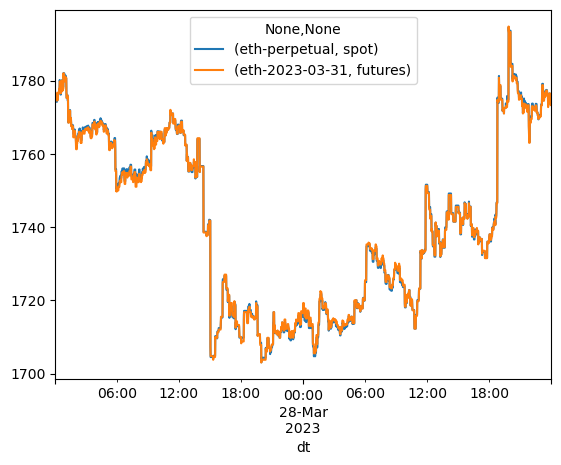

In [140]:
data.plot()

In [155]:
calls = [(inst, int(inst[12:][:-2])) for inst in df.instrument.value_counts().keys() \
       if inst[-2:] =='-C' and int(inst[12:][:-2]) >= 1800 and int(inst[12:][:-2]) <= 2200]
calls.sort()
calls

[('ETH-31MAR23-1800-C', 1800),
 ('ETH-31MAR23-1900-C', 1900),
 ('ETH-31MAR23-2000-C', 2000),
 ('ETH-31MAR23-2100-C', 2100),
 ('ETH-31MAR23-2200-C', 2200)]

In [156]:
call, strike = calls[0]
data_call = df[df.instrument == call][['dt', 'price']].set_index('dt')
data_call = data_call.resample('1min').ohlc().ffill()[('price', 'close')]\
    .rename(('eth-2023-03-31-call', strike))
data_call

dt
2023-03-27 00:03:00    0.0210
2023-03-27 00:04:00    0.0210
2023-03-27 00:05:00    0.0210
2023-03-27 00:06:00    0.0210
2023-03-27 00:07:00    0.0210
                        ...  
2023-03-28 23:55:00    0.0125
2023-03-28 23:56:00    0.0125
2023-03-28 23:57:00    0.0125
2023-03-28 23:58:00    0.0125
2023-03-28 23:59:00    0.0125
Freq: T, Name: (eth-2023-03-31-call, 1800), Length: 2877, dtype: float64

In [157]:
for call, strike in calls[1:]:
    data_call_ = df[df.instrument == call][['dt', 'price']].set_index('dt')
    data_call_ = data_call_.resample('1min').ohlc().ffill()[('price', 'close')]\
        .rename(('eth-2023-03-31-call', strike))
    data_call = pd.merge(data_call, data_call_, on='dt', how='inner')

In [158]:
data_call

eth-2023-03-31-call                               
                                   1800   1900    2000    2100    2200
dt                                                                    
2023-03-27 00:03:00              0.0210  0.007  0.0030  0.0015  0.0010
2023-03-27 00:04:00              0.0210  0.007  0.0030  0.0015  0.0010
2023-03-27 00:05:00              0.0210  0.007  0.0030  0.0015  0.0010
2023-03-27 00:06:00              0.0210  0.007  0.0030  0.0015  0.0010
2023-03-27 00:07:00              0.0210  0.007  0.0030  0.0015  0.0010
...                                 ...    ...     ...     ...     ...
2023-03-28 23:53:00              0.0125  0.003  0.0015  0.0005  0.0005
2023-03-28 23:54:00              0.0125  0.003  0.0015  0.0005  0.0005
2023-03-28 23:55:00              0.0125  0.003  0.0015  0.0005  0.0005
2023-03-28 23:56:00              0.0125  0.003  0.0015  0.0005  0.0005
2023-03-28 23:57:00              0.0125  0.003  0.0015  0.0005  0.0005

[2875 rows x 5 columns]

<Axes: xlabel='dt'>

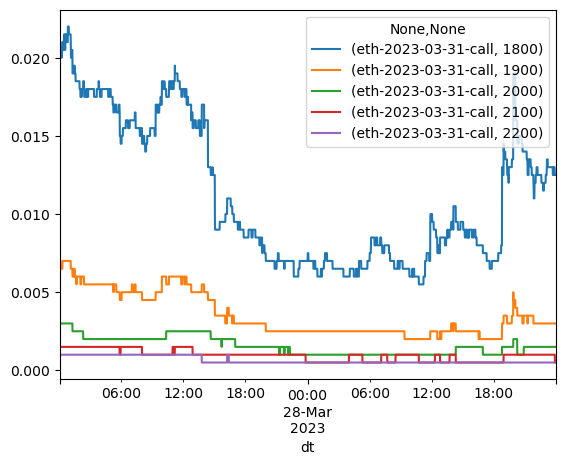

In [159]:
data_call.plot()

In [160]:
puts = [(inst, int(inst[12:][:-2])) for inst in df.instrument.value_counts().keys() \
       if inst[-2:] =='-P' and int(inst[12:][:-2]) >= 1300 and int(inst[12:][:-2]) <= 1700]
puts.sort()
puts

[('ETH-31MAR23-1300-P', 1300),
 ('ETH-31MAR23-1400-P', 1400),
 ('ETH-31MAR23-1500-P', 1500),
 ('ETH-31MAR23-1600-P', 1600),
 ('ETH-31MAR23-1700-P', 1700)]

In [161]:
put, strike = puts[0]
data_put = df[df.instrument == put][['dt', 'price']].set_index('dt')
data_put = data_put.resample('1min').ohlc().ffill()[('price', 'close')]\
    .rename(('eth-2023-03-31-put', strike))

In [162]:
for put, strike in puts[1:]:
    data_put_ = df[df.instrument == put][['dt', 'price']].set_index('dt')
    data_put_ = data_put_.resample('1min').ohlc().ffill()[('price', 'close')]\
        .rename(('eth-2023-03-31-put', strike))
    data_put = pd.merge(data_put, data_put_, on='dt', how='inner')
data_put

eth-2023-03-31-put                               
                                  1300    1400   1500    1600    1700
dt                                                                   
2023-03-27 00:03:00             0.0010  0.0015  0.002  0.0040  0.0115
2023-03-27 00:04:00             0.0010  0.0015  0.002  0.0040  0.0115
2023-03-27 00:05:00             0.0010  0.0015  0.002  0.0040  0.0115
2023-03-27 00:06:00             0.0010  0.0015  0.002  0.0040  0.0115
2023-03-27 00:07:00             0.0010  0.0015  0.002  0.0040  0.0115
...                                ...     ...    ...     ...     ...
2023-03-28 23:53:00             0.0005  0.0005  0.001  0.0015  0.0055
2023-03-28 23:54:00             0.0005  0.0005  0.001  0.0015  0.0055
2023-03-28 23:55:00             0.0005  0.0005  0.001  0.0015  0.0055
2023-03-28 23:56:00             0.0005  0.0005  0.001  0.0015  0.0055
2023-03-28 23:57:00             0.0005  0.0005  0.001  0.0015  0.0055

[2875 rows x 5 columns]

<Axes: xlabel='dt'>

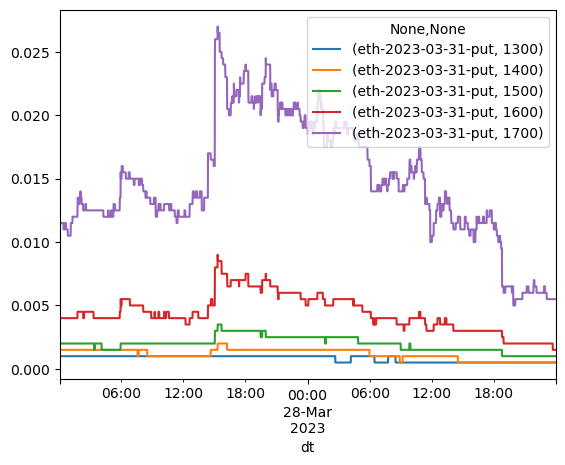

In [163]:
data_put.plot()

In [164]:
data = pd.merge(data, data_put, on='dt', how='inner')
data

eth-perpetual eth-2023-03-31 eth-2023-03-31-put          \
                             spot        futures               1300    1400   
dt                                                                            
2023-03-27 00:03:00       1776.15        1776.75             0.0010  0.0015   
2023-03-27 00:04:00       1776.15        1776.50             0.0010  0.0015   
2023-03-27 00:05:00       1776.15        1776.50             0.0010  0.0015   
2023-03-27 00:06:00       1776.15        1776.50             0.0010  0.0015   
2023-03-27 00:07:00       1776.15        1776.50             0.0010  0.0015   
...                           ...            ...                ...     ...   
2023-03-28 23:53:00       1775.20        1774.75             0.0005  0.0005   
2023-03-28 23:54:00       1774.95        1774.50             0.0005  0.0005   
2023-03-28 23:55:00       1774.95        1774.50             0.0005  0.0005   
2023-03-28 23:56:00       1774.95        1774.50             0.0005  0.0005   
2023-03-28 23:57:00       1773.65        1773.25             0.0005  0.0005   

                                            
                      1500    1600    1700  
dt                                          
2023-03-27 00:03:00  0.002  0.0040  0.0115  
2023-03-27 00:04:00  0.002  0.0040  0.0115  
2023-03-27 00:05:00  0.002  0.0040  0.0115  
2023-03-27 00:06:00  0.002  0.0040  0.0115  
2023-03-27 00:07:00  0.002  0.0040  0.0115  
...                    ...     ...     ...  
2023-03-28 23:53:00  0.001  0.0015  0.0055  
2023-03-28 23:54:00  0.001  0.0015  0.0055  
2023-03-28 23:55:00  0.001  0.0015  0.0055  
2023-03-28 23:56:00  0.001  0.0015  0.0055  
2023-03-28 23:57:00  0.001  0.0015  0.0055  

[2875 rows x 7 columns]

In [165]:
data = pd.merge(data, data_call, on='dt', how='inner')
data

eth-perpetual eth-2023-03-31 eth-2023-03-31-put          \
                             spot        futures               1300    1400   
dt                                                                            
2023-03-27 00:03:00       1776.15        1776.75             0.0010  0.0015   
2023-03-27 00:04:00       1776.15        1776.50             0.0010  0.0015   
2023-03-27 00:05:00       1776.15        1776.50             0.0010  0.0015   
2023-03-27 00:06:00       1776.15        1776.50             0.0010  0.0015   
2023-03-27 00:07:00       1776.15        1776.50             0.0010  0.0015   
...                           ...            ...                ...     ...   
2023-03-28 23:53:00       1775.20        1774.75             0.0005  0.0005   
2023-03-28 23:54:00       1774.95        1774.50             0.0005  0.0005   
2023-03-28 23:55:00       1774.95        1774.50             0.0005  0.0005   
2023-03-28 23:56:00       1774.95        1774.50             0.0005  0.0005   
2023-03-28 23:57:00       1773.65        1773.25             0.0005  0.0005   

                                           eth-2023-03-31-call                 \
                      1500    1600    1700                1800   1900    2000   
dt                                                                              
2023-03-27 00:03:00  0.002  0.0040  0.0115              0.0210  0.007  0.0030   
2023-03-27 00:04:00  0.002  0.0040  0.0115              0.0210  0.007  0.0030   
2023-03-27 00:05:00  0.002  0.0040  0.0115              0.0210  0.007  0.0030   
2023-03-27 00:06:00  0.002  0.0040  0.0115              0.0210  0.007  0.0030   
2023-03-27 00:07:00  0.002  0.0040  0.0115              0.0210  0.007  0.0030   
...                    ...     ...     ...                 ...    ...     ...   
2023-03-28 23:53:00  0.001  0.0015  0.0055              0.0125  0.003  0.0015   
2023-03-28 23:54:00  0.001  0.0015  0.0055              0.0125  0.003  0.0015   
2023-03-28 23:55:00  0.001  0.0015  0.0055              0.0125  0.003  0.0015   
2023-03-28 23:56:00  0.001  0.0015  0.0055              0.0125  0.003  0.0015   
2023-03-28 23:57:00  0.001  0.0015  0.0055              0.0125  0.003  0.0015   

                                     
                       2100    2200  
dt                                   
2023-03-27 00:03:00  0.0015  0.0010  
2023-03-27 00:04:00  0.0015  0.0010  
2023-03-27 00:05:00  0.0015  0.0010  
2023-03-27 00:06:00  0.0015  0.0010  
2023-03-27 00:07:00  0.0015  0.0010  
...                     ...     ...  
2023-03-28 23:53:00  0.0005  0.0005  
2023-03-28 23:54:00  0.0005  0.0005  
2023-03-28 23:55:00  0.0005  0.0005  
2023-03-28 23:56:00  0.0005  0.0005  
2023-03-28 23:57:00  0.0005  0.0005  

[2875 rows x 12 columns]

In [166]:
data.to_csv('data.csv')

In [52]:
csv_data = pd.read_csv('mif_applied_derivatives_data.csv', header=[0,1], index_col=0)
csv_data

eth-perpetual eth-2023-03-31 eth-2023-03-31-put          \
                             spot        futures               1300    1400   
dt                                                                            
2023-03-27 00:03:00       1776.15        1776.75             0.0010  0.0015   
2023-03-27 00:04:00       1776.15        1776.50             0.0010  0.0015   
2023-03-27 00:05:00       1776.15        1776.50             0.0010  0.0015   
2023-03-27 00:06:00       1776.15        1776.50             0.0010  0.0015   
2023-03-27 00:07:00       1776.15        1776.50             0.0010  0.0015   
...                           ...            ...                ...     ...   
2023-03-28 23:53:00       1775.20        1774.75             0.0005  0.0005   
2023-03-28 23:54:00       1774.95        1774.50             0.0005  0.0005   
2023-03-28 23:55:00       1774.95        1774.50             0.0005  0.0005   
2023-03-28 23:56:00       1774.95        1774.50             0.0005  0.0005   
2023-03-28 23:57:00       1773.65        1773.25             0.0005  0.0005   

                                           eth-2023-03-31-call                 \
                      1500    1600    1700                1800   1900    2000   
dt                                                                              
2023-03-27 00:03:00  0.002  0.0040  0.0115              0.0210  0.007  0.0030   
2023-03-27 00:04:00  0.002  0.0040  0.0115              0.0210  0.007  0.0030   
2023-03-27 00:05:00  0.002  0.0040  0.0115              0.0210  0.007  0.0030   
2023-03-27 00:06:00  0.002  0.0040  0.0115              0.0210  0.007  0.0030   
2023-03-27 00:07:00  0.002  0.0040  0.0115              0.0210  0.007  0.0030   
...                    ...     ...     ...                 ...    ...     ...   
2023-03-28 23:53:00  0.001  0.0015  0.0055              0.0125  0.003  0.0015   
2023-03-28 23:54:00  0.001  0.0015  0.0055              0.0125  0.003  0.0015   
2023-03-28 23:55:00  0.001  0.0015  0.0055              0.0125  0.003  0.0015   
2023-03-28 23:56:00  0.001  0.0015  0.0055              0.0125  0.003  0.0015   
2023-03-28 23:57:00  0.001  0.0015  0.0055              0.0125  0.003  0.0015   

                                     
                       2100    2200  
dt                                   
2023-03-27 00:03:00  0.0015  0.0010  
2023-03-27 00:04:00  0.0015  0.0010  
2023-03-27 00:05:00  0.0015  0.0010  
2023-03-27 00:06:00  0.0015  0.0010  
2023-03-27 00:07:00  0.0015  0.0010  
...                     ...     ...  
2023-03-28 23:53:00  0.0005  0.0005  
2023-03-28 23:54:00  0.0005  0.0005  
2023-03-28 23:55:00  0.0005  0.0005  
2023-03-28 23:56:00  0.0005  0.0005  
2023-03-28 23:57:00  0.0005  0.0005  

[2875 rows x 12 columns]

In [53]:
csv_data.dtypes

eth-perpetual        spot       float64
eth-2023-03-31       futures    float64
eth-2023-03-31-put   1300       float64
                     1400       float64
                     1500       float64
                     1600       float64
                     1700       float64
eth-2023-03-31-call  1800       float64
                     1900       float64
                     2000       float64
                     2100       float64
                     2200       float64
dtype: object

In [57]:
csv_data['eth-2023-03-31-put'].values

array([[0.001 , 0.0015, 0.002 , 0.004 , 0.0115],
       [0.001 , 0.0015, 0.002 , 0.004 , 0.0115],
       [0.001 , 0.0015, 0.002 , 0.004 , 0.0115],
       ...,
       [0.0005, 0.0005, 0.001 , 0.0015, 0.0055],
       [0.0005, 0.0005, 0.001 , 0.0015, 0.0055],
       [0.0005, 0.0005, 0.001 , 0.0015, 0.0055]])

In [7]:
np.array([int(strike) for strike in csv_data['eth-2023-03-31-put'].columns])

array([1300, 1400, 1500, 1600, 1700])

In [10]:
csv_data['diff'] = csv_data['eth-2023-03-31-put']['1300'].diff()

In [12]:
csv_data[csv_data['diff'] != 0]

eth-perpetual eth-2023-03-31 eth-2023-03-31-put          \
                             spot        futures               1300    1400   
dt                                                                            
2023-03-27 00:03:00       1776.15        1776.75             0.0010  0.0015   
2023-03-28 02:41:00       1712.20        1712.50             0.0005  0.0015   
2023-03-28 04:11:00       1712.90        1713.25             0.0010  0.0015   
2023-03-28 06:28:00       1733.55        1734.25             0.0005  0.0010   
2023-03-28 07:47:00       1730.45        1731.00             0.0010  0.0010   
2023-03-28 08:30:00       1723.30        1723.75             0.0005  0.0010   

                                            eth-2023-03-31-call          \
                       1500    1600    1700                1800    1900   
dt                                                                        
2023-03-27 00:03:00  0.0020  0.0040  0.0115              0.0210  0.0070   
2023-03-28 02:41:00  0.0025  0.0055  0.0195              0.0065  0.0025   
2023-03-28 04:11:00  0.0025  0.0055  0.0190              0.0065  0.0025   
2023-03-28 06:28:00  0.0020  0.0040  0.0140              0.0080  0.0025   
2023-03-28 07:47:00  0.0020  0.0040  0.0145              0.0080  0.0025   
2023-03-28 08:30:00  0.0020  0.0040  0.0155              0.0065  0.0025   

                                              diff  
                      2000    2100    2200          
dt                                                  
2023-03-27 00:03:00  0.003  0.0015  0.0010     NaN  
2023-03-28 02:41:00  0.001  0.0005  0.0005 -0.0005  
2023-03-28 04:11:00  0.001  0.0010  0.0005  0.0005  
2023-03-28 06:28:00  0.001  0.0005  0.0005 -0.0005  
2023-03-28 07:47:00  0.001  0.0005  0.0005  0.0005  
2023-03-28 08:30:00  0.001  0.0010  0.0005 -0.0005

In [34]:
dff = csv_data[(csv_data.date < pd.Timestamp('2023-03-28 08:35:00')) & \
         (csv_data.date > pd.Timestamp('2023-03-28 08:25:00'))]

dff

eth-perpetual eth-2023-03-31 eth-2023-03-31-put         \
                             spot        futures               1300   1400   
dt                                                                           
2023-03-28 08:26:00        1723.4        1723.75             0.0010  0.001   
2023-03-28 08:27:00        1723.4        1723.75             0.0010  0.001   
2023-03-28 08:28:00        1723.4        1723.75             0.0010  0.001   
2023-03-28 08:29:00        1723.4        1723.75             0.0010  0.001   
2023-03-28 08:30:00        1723.3        1723.75             0.0005  0.001   
2023-03-28 08:31:00        1722.6        1723.25             0.0005  0.001   
2023-03-28 08:32:00        1722.6        1723.25             0.0005  0.001   
2023-03-28 08:33:00        1722.6        1723.25             0.0005  0.001   
2023-03-28 08:34:00        1722.6        1723.25             0.0005  0.001   

                                          eth-2023-03-31-call                 \
                      1500   1600    1700                1800    1900   2000   
dt                                                                             
2023-03-28 08:26:00  0.002  0.004  0.0155              0.0065  0.0025  0.001   
2023-03-28 08:27:00  0.002  0.004  0.0155              0.0065  0.0025  0.001   
2023-03-28 08:28:00  0.002  0.004  0.0155              0.0065  0.0025  0.001   
2023-03-28 08:29:00  0.002  0.004  0.0155              0.0065  0.0025  0.001   
2023-03-28 08:30:00  0.002  0.004  0.0155              0.0065  0.0025  0.001   
2023-03-28 08:31:00  0.002  0.004  0.0155              0.0065  0.0025  0.001   
2023-03-28 08:32:00  0.002  0.004  0.0155              0.0065  0.0025  0.001   
2023-03-28 08:33:00  0.002  0.004  0.0155              0.0065  0.0025  0.001   
2023-03-28 08:34:00  0.002  0.004  0.0155              0.0065  0.0025  0.001   

                                       diff                date  
                       2100    2200                              
dt                                                               
2023-03-28 08:26:00  0.0005  0.0005  0.0000 2023-03-28 08:26:00  
2023-03-28 08:27:00  0.0005  0.0005  0.0000 2023-03-28 08:27:00  
2023-03-28 08:28:00  0.0005  0.0005  0.0000 2023-03-28 08:28:00  
2023-03-28 08:29:00  0.0005  0.0005  0.0000 2023-03-28 08:29:00  
2023-03-28 08:30:00  0.0010  0.0005 -0.0005 2023-03-28 08:30:00  
2023-03-28 08:31:00  0.0010  0.0005  0.0000 2023-03-28 08:31:00  
2023-03-28 08:32:00  0.0010  0.0005  0.0000 2023-03-28 08:32:00  
2023-03-28 08:33:00  0.0010  0.0005  0.0000 2023-03-28 08:33:00  
2023-03-28 08:34:00  0.0010  0.0005  0.0000 2023-03-28 08:34:00

In [45]:
puts = dff.loc['2023-03-28 08:29:00', 'eth-2023-03-31-put'].values.astype(np.float64)
calls = dff.loc['2023-03-28 08:29:00', 'eth-2023-03-31-call'].values.astype(np.float64)
forward = dff.loc['2023-03-28 08:29:00', 'eth-2023-03-31'].values.astype(np.float64)
forward

array([1723.75])

In [46]:
puts*forward

array([ 1.72375 ,  1.72375 ,  3.4475  ,  6.895   , 26.718125])

In [47]:
calls*forward

array([11.204375,  4.309375,  1.72375 ,  0.861875,  0.861875])

In [49]:
new_puts = dff.loc['2023-03-28 08:31:00', 'eth-2023-03-31-put'].values.astype(np.float64)
new_calls = dff.loc['2023-03-28 08:31:00', 'eth-2023-03-31-call'].values.astype(np.float64)
new_forward = dff.loc['2023-03-28 08:31:00', 'eth-2023-03-31'].values.astype(np.float64)
new_forward

array([1723.25])

In [50]:
new_puts*new_forward

array([ 0.861625,  1.72325 ,  3.4465  ,  6.893   , 26.710375])

In [51]:
new_calls*new_forward

array([11.201125,  4.308125,  1.72325 ,  1.72325 ,  0.861625])